# Figure Notebook

In [1]:
"""
Import needed libraries
"""

import numpy as np
import pandas as pd
from copy import copy
import sys
import my_shell_tools

# analysis
from scipy.stats import ttest_ind_from_stats
import itertools

# geomip_data
import os.path
# import cf
from netCDF4 import Dataset

# plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.colors import LogNorm

%load_ext autoreload
%autoreload 2

In [2]:
"""
Import all from projects python scripts
"""

from gfdl_data import *
from get_glens_data import *
from analysis import *
from plotting import *

In [3]:
"""
How much of this needed?
"""

# Directory and filenames for annual timeseries of 2D data
glens_dir = '/n/home03/pjirvine/keithfs1_pji/GLENS/combined_annual_data/'
glens_template = '{exp}.{run}.cam.h0.{var}.ann.{years}.nc'

vars_glens = ['TREFHT','TREFHTMX','P-E','PRECTMX','PRECT']
exps_glens = ['control','feedback']
years = ['2010-2029','2075-2094']

# year ranges which appears in filename
control_file_years = '201001-209912'
control_short_file_years = '201001-203012'
feedback_file_years = '202001-209912'

seas = 'ann'
stats = ['mean','std']

"""
Specify years of experiments and associated indices for annual files
"""

years_control = np.array([IDX + 2010 for IDX in range(90)])
years_feedback = np.array([IDX + 2020 for IDX in range(80)])

#Generate the indices for the range of years in each case.
# [0] added as a 2 element tuple with an array and an empty slot returned rather than an array
t_index_control = np.where((years_control > 2074) & (years_control < 2095))[0]
t_index_baseline = np.where((years_control > 2009) & (years_control < 2030))[0]
t_index_feedback = np.where((years_feedback > 2074) & (years_feedback < 2095))[0]

# Years when GLENS anom = half eventual cooling found using offline calculation with this function call: closest_years_to_frac_GLENS(0.5)
t_index_feedback_half = np.where((years_feedback > 2043) & (years_feedback < 2064))[0]
t_index_control_half = np.where((years_control > 2043) & (years_control < 2064))[0]

"""
How much of this needed?
"""

'\nHow much of this needed?\n'

In [4]:
"""
Generate means and stds for all variables and cases
"""

# get lons, lats and weights
lons, lats, weights = get_lons_lats_weights()

# returnes (Means, Stds) for all cases and vars
all_data = get_all_cases_vars() # {(var,case)}
"""
CASES:
'Baseline'     - RCP8.5 @ 2010-2029
'RCP8.5'       - RCP8.5 @ 2075-2094
'Full-GLENS'   - GLENS  @ 2075-2094
'Half-GLENS'   - Scaled Half-GLENS  @ 2075-2094
'Baseline-2'   - RCP8.5 @ 2010-2029 W/ alternate runs
'Full-GLENS-2'   - GLENS @ 2075-2094 W/ alternate runs
'Half-GLENS-2'   - Scaled Half-GLENS @ 2075-2094 W/ alternate runs on GLENS (not on RCP8.5)
### NOT DONE ### 'Half-GLENS-time' - Shifted Half-GLENS @ 2075-2094 AND ?????
"""

# get weights and masks
all_masks = get_glens_masks_weights() # all_masks[masks]
"""
MASKS:
'land_frac' - Land fraction
'land_mask' - binary land mask where land fraction > 50%
'land_noice_frac' land fraction without Greenland or Antarctica
'land_noice_mask' - binary land mask without Greenland or Antarctica and where land fraction > 50%
    
WEIGHTS:
'pop' - gridcell weighting by population fraction
'ag' - gridcell weighting by agricultural land fraction
'area' - simple gridcell weighting by area
'land_area' - land area weighting using raw land area fraction (not mask)
'land_noice_area' - land area without Greenland and Antarctica weighting using raw land area fraction (not mask)
"""


"\nMASKS:\n'land_frac' - Land fraction\n'land_mask' - binary land mask where land fraction > 50%\n'land_noice_frac' land fraction without Greenland or Antarctica\n'land_noice_mask' - binary land mask without Greenland or Antarctica and where land fraction > 50%\n    \nWEIGHTS:\n'pop' - gridcell weighting by population fraction\n'ag' - gridcell weighting by agricultural land fraction\n'area' - simple gridcell weighting by area\n'land_area' - land area weighting using raw land area fraction (not mask)\n'land_noice_area' - land area without Greenland and Antarctica weighting using raw land area fraction (not mask)\n"

In [5]:
"""
Set standard plot options
"""

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

plt.rcParams.update({'font.size': 8})
plt.rcParams.update({'figure.figsize': cm2inch(8.5,8.5)})

# color guide here: https://www.w3schools.com/colors/colors_picker.asp
# color blender here: https://meyerweb.com/eric/tools/color-blend
red = '#ff0000'
l_red = '#ffc0c0' # old: '#ffd9d9'
blue = '#0066ff'
l_blue = '#c0c0ff' # old:'#b2d0ff'
purple = '#803380'
l_purple = '#C099C0' 

std_alpha = 0.2

In [6]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300 # set inline images to hi-res
%matplotlib inline

# INSERT FIGURE SECTIONS HERE

# Loading Example NetCDF to see contents and map results

In [ ]:
"""
Example netcdf file of annual series + gather lons and lats
"""

"""
variables(dimensions): float64 time(time), float64 time_bnds(time,bnds), 
    float64 lat(lat), float64 lon(lon), float64 gw(lat), float64 ch4vmr(time), 
    float64 co2vmr(time), int32 ndcur(time), int32 date(time), int32 nscur(time), 
    float64 sol_tsi(time), int32 nsteph(time), float64 f11vmr(time), float64 n2ovmr(time), 
    int32 datesec(time), float64 f12vmr(time), float32 TREFHT(time,lat,lon)
"""

var='TREFHT'
exp='control'
run='001'
file_years='201001-209912'

glens_dir = '/n/home03/pjirvine/keithfs1_pji/GLENS/combined_annual_data/'
glens_filename = '{exp}.{run}.cam.h0.{var}.ann.{years}.nc'.format(exp=exp,run=run,var=var,years=file_years)

glens_fileloc = glens_dir + glens_filename
test_nc = Dataset(glens_fileloc)

lons = np.array(test_nc.variables['lon'][:])
lats = np.array(test_nc.variables['lat'][:])

# grid-weights by latitude
gw = test_nc.variables['gw'][:]
gw_2D = np.tile(gw, (lons.size,1))
gw_2D = gw_2D / np.sum(gw_2D)

In [ ]:
# #Get example netcdf
# glens_dir = '/n/home03/pjirvine/keithfs1_pji/GLENS/combined_annual_data/'
# glens_filename = 'control.001.cam.h0.TREFHT.ann.201001-209912.nc'
# glens_fileloc = glens_dir + glens_filename
# test_nc = Dataset(glens_fileloc)

fix_dir = '/n/home03/pjirvine/keithfs1_pji/geomip_archive/final_data/CCSM4/fix/'
filename = 'sftlf_CCSM4.nc'
test_nc = Dataset(fix_dir + filename)

nc_data = test_nc.variables['sftlf'][:].transpose()

In [ ]:
nc_data.shape

In [ ]:
    """
    MASKS:
    'land_mask' - binary land mask where land fraction > 50%
    'land_noice_mask' - binary land mask without Greenland or Antarctica and where land fraction > 50%
    WEIGHTS:
    'pop' - gridcell weighting by population fraction
    'ag' - gridcell weighting by agricultural land fraction
    'area' - simple gridcell weighting by area
    'land_area' - land area weighting using raw land area fraction (not mask)
    'land_noice_area' - land area without Greenland and Antarctica weighting using raw land area fraction (not mask)
    """

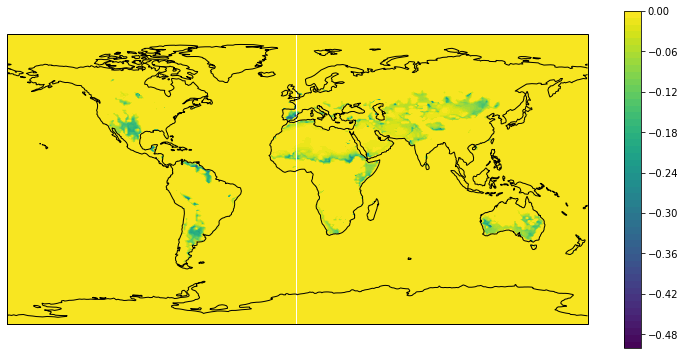

masked_array(
  data=[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

In [28]:
"""
Example cartopy plot

http://earthpy.org/tag/cartopy.html
https://scitools.org.uk/cartopy/docs/v0.16/matplotlib/advanced_plotting.html
"""

import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
from matplotlib import cm
import cartopy.crs as ccrs

from cartopy.util import add_cyclic_point

# #Get example netcdf
# glens_dir = '/n/home03/pjirvine/keithfs1_pji/GLENS/combined_annual_data/'
# glens_filename = 'control.001.cam.h0.TREFHT.ann.201001-209912.nc'
# glens_fileloc = glens_dir + glens_filename
# test_nc = Dataset(glens_fileloc)

# nc_data = test_nc.variables['TREFHT'][:].transpose()
# data = np.mean(nc_data,2)

# data = all_masks['land_noice_mask'].transpose()
mask = all_masks['land_noice_mask']#.transpose()

data = all_data[('P-E','Baseline')][0] * (all_data[('P-E','Baseline')][0] < 0) * (all_data[('P-E','Baseline')][0] > -0.5) * mask
# data = all_data[('P-E','Full-GLENS')][0] * (all_data[('P-E','Full-GLENS')][0] < 0) * (all_data[('P-E','Full-GLENS')][0] > -1.0) * mask
# data = all_data[('P-E','RCP8.5')][0] * (all_data[('P-E','RCP8.5')][0] < 0) * (all_data[('P-E','RCP8.5')][0] > -1.0) * mask
# data = np.transpose(all_masks['land_frac'])

fig = plt.figure(figsize=(13,6.2))  
# ax = plt.subplot(111, projection=ccrs.PlateCarree())

ax = plt.axes(projection=ccrs.PlateCarree())

# plt.figure(figsize=(13,6.2))  
# ax = plt.subplot(111, projection=ccrs.PlateCarree())

lons2d, lats2d = np.meshgrid(lons, lats)

CS = plt.contourf(lons2d, lats2d, data.transpose(), 60,
             transform=ccrs.PlateCarree())

ax.coastlines()

fig.colorbar(CS) #cm.ScalarMappable(),ax=ax)

plt.show()

data

In [ ]:
plt.imshow(all_data[('P-E','RCP8.5')][0])